In [9]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option("display.max_colwidth", -1)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Dropout,Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from PIL import Image, ImageStat
import math

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
#seeding
seed = 2022
np.random.seed = seed
tf.seed = seed

In [11]:
# !mkdir train test

In [12]:
# print('Unzipping stage1_train.zip')
# !unzip -q "./Datasets/stage1_train.zip" -d train/
# print('Unzipped stage1_train.zip')

# print('Unzipping stage1_test.zip')
# !unzip -q "./Datasets/stage1_test.zip" -d test/
# print('Unzipped stage1_test.zip')

## Defining test and train Directories

In [13]:
TRAIN_ROOT_DIR = 'train'
TEST_ROOT_DIR = 'test'

In [14]:
# Function to create a dataframe of files which will be used for further processing
def files_df(root_dir):
    subdir = os.listdir(root_dir)
    files = []
    df = pd.DataFrame()
    for dir in subdir:
        files.append(os.path.join(root_dir,dir))
    df['files'] = files
    return df

In [15]:
train_df = files_df(TRAIN_ROOT_DIR)
test_df = files_df(TEST_ROOT_DIR)

In [16]:
train_df.head(2)

,files
0,train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
1,train\003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1


In [17]:
test_df.head(2)

,files
0,test\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
1,test\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


In [18]:
# Image parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
CLASSES = 3
BATCH_SIZE = 8

In [19]:
def image_df(filenames):
    image_paths = []
    mask_paths = []
    df = pd.DataFrame()
    for filename in tqdm(filenames):
        file_path = os.path.join(filename,'images')
        image_path = os.path.join(file_path,os.listdir(file_path)[0])
        image_paths.append(image_path)
        
        mask = np.zeros((IMG_WIDTH,IMG_HEIGHT,1))
        mask_dir = file_path.replace("images", "masks")
        masks = os.listdir(mask_dir)
        for m in masks:
            mask_path = os.path.join(mask_dir,m)
            mask_  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask_  = cv2.resize(mask_,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_NEAREST)
            mask_  = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask,mask_)
        newmask_dir = mask_dir.replace("masks", "masks_")
        if not os.path.isdir(newmask_dir):
            os.mkdir(newmask_dir)
        newmask_path = image_path.replace("images", "masks_")
        mask_paths.append(newmask_path)
        cv2.imwrite(newmask_path, mask)
    df['images'] = image_paths
    df['masks'] = mask_paths
    return df

In [20]:
train_filenames = train_df['files']
train = image_df(train_filenames)

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:55<00:00,  5.80it/s]


## Splitting train and test data

In [21]:
X_train, X_val = train_test_split(train, test_size=0.1, random_state=42)

In [22]:
X_train.head()

,images,masks
300,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\images\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\masks_\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png
60,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\images\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\masks_\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png
133,train\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722\images\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722.png,train\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722\masks_\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722.png
30,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\images\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\masks_\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png
69,train\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df\images\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df.png,train\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df\masks_\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df.png


In [23]:
X_val.head()

,images,masks
361,train\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832\images\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832.png,train\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832\masks_\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832.png
158,train\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9\images\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9.png,train\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9\masks_\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9.png
480,train\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c\images\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c.png,train\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c\masks_\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c.png
640,train\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a\images\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a.png,train\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a\masks_\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a.png
275,train\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3\images\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3.png,train\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3\masks_\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3.png


# Preprocessing the data

In [24]:
# Function to parse image and mask file path and convert them into image and mask
def parse_function(image_path, mask_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=IMG_CHANNELS)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])                      
    return image, mask

In [25]:
# Function to perform data augmentation
def train_preprocess(image, mask):
    a = tf.random.uniform(())
    if a<0.2:
        image = tf.image.random_flip_left_right(image)
        mask = tf.image.random_flip_left_right(mask)
    elif a<0.4:
        image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
        mask = tf.image.random_brightness(mask, max_delta=32.0 / 255.0)
    elif a<0.6:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        mask = tf.image.random_saturation(mask, lower=0.5, upper=1.5)
    elif a<0.8:
        image = tf.image.random_flip_up_down(image)
        mask = tf.image.random_flip_up_down(mask)
    else:
        image = tf.image.random_hue(image, 0.2)
        mask = tf.image.random_hue(mask, 0.2)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    mask = tf.clip_by_value(mask, 0.0, 1.0)
    return image, mask

In [26]:
# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train['images'], X_train['masks']))
train_ds = train_ds.shuffle(X_train.shape[0])
train_ds = train_ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(1)

print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


In [27]:
# Validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val['images'], X_val['masks']))
val_ds = val_ds.shuffle(X_val.shape[0])
val_ds = val_ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(1)

# Sample of Train and Validation datasets

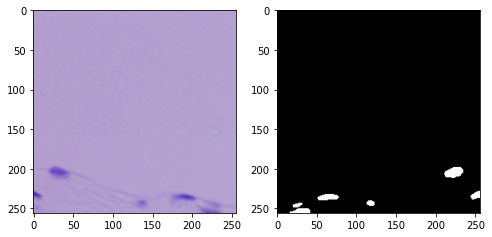

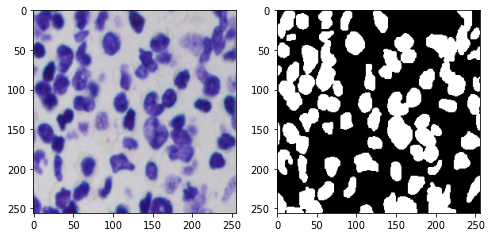

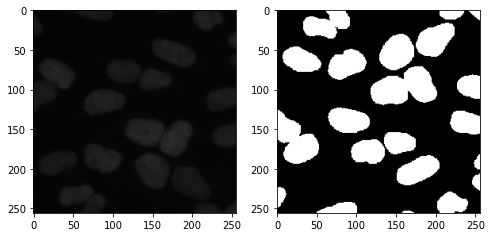

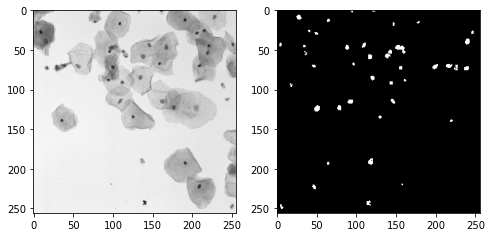

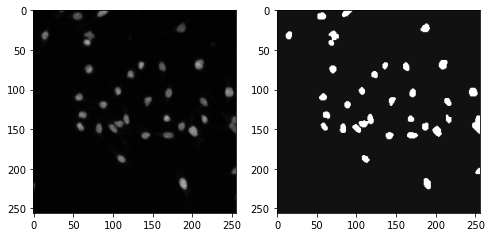

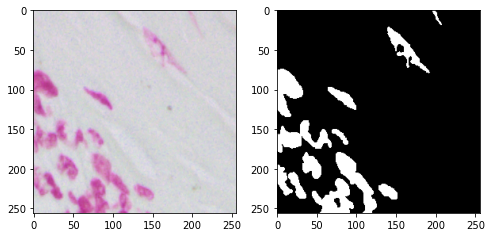

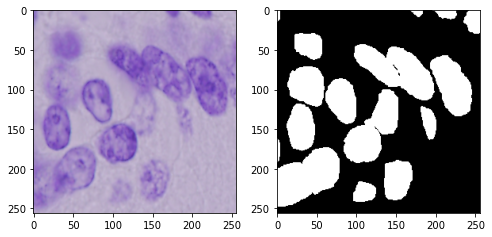

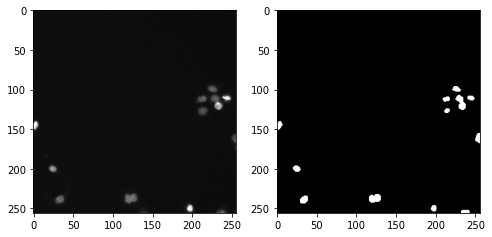

In [28]:
# Sample of training dataset
for image, mask in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.imshow(image[i])
        plt.subplot(122)
        plt.imshow(mask[i], cmap = 'gray')
        plt.show()

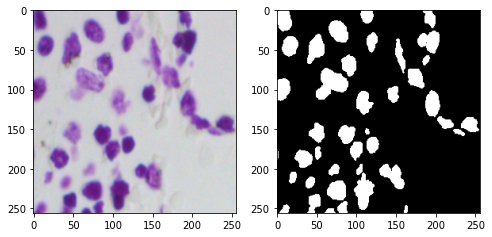

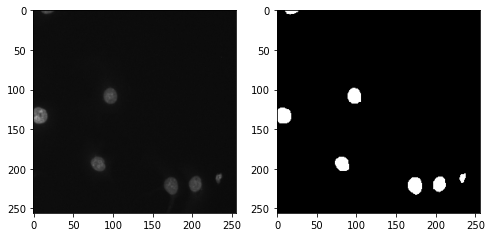

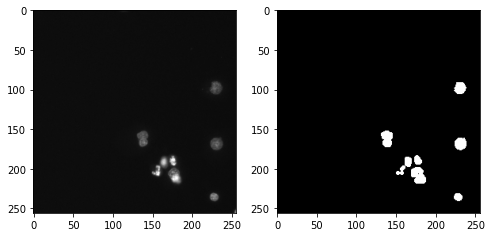

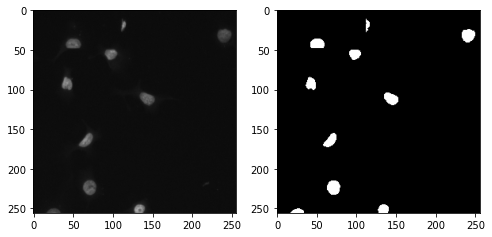

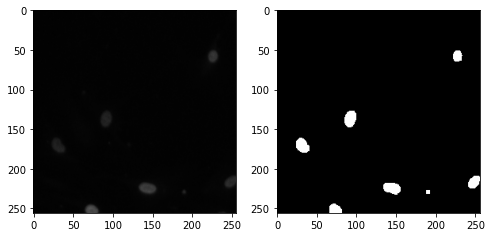

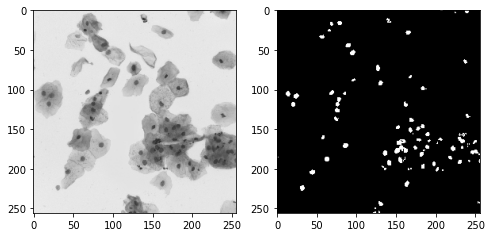

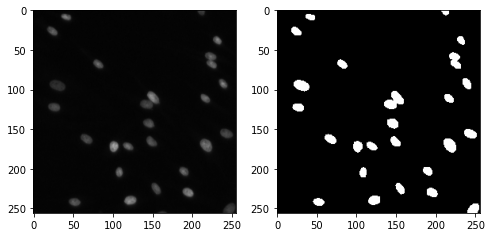

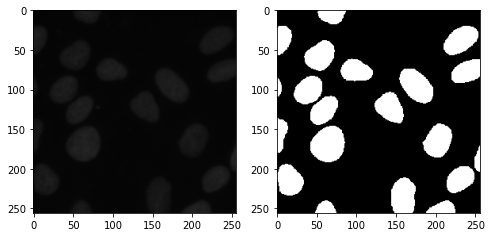

In [29]:
# Sample of validation dataset
for image, mask in val_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.imshow(image[i])
        plt.subplot(122)
        plt.imshow(mask[i], cmap = 'gray')
        plt.show()

# Creating model

## UNet = Convolutional Networks for Biomedical Image Segmentation

In [30]:
# Custom MeanIoU Metric function
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, thres=0.5, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.thres = thres
        self.total_cm = self.add_weight('total_confusion_matrix',
                                        shape=(num_classes, num_classes),
                                        initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        
        y_pred = tf.where(y_pred > self.thres, 1.0, 0.0)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])
        current_cm = tf.math.confusion_matrix(y_true,
                                              y_pred,
                                              self.num_classes,
                                              weights=sample_weight,
                                              dtype=self._dtype)
        
        return self.total_cm.assign_add(current_cm)
    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)
        denominator = sum_over_row + sum_over_col - true_positives
        num_valid_entries = tf.reduce_sum(tf.cast(tf.math.not_equal(denominator, 0), dtype=self._dtype))
        iou = tf.math.divide_no_nan(true_positives, denominator)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        tf.keras.backend.set_value(self.total_cm, np.zeros((self.num_classes, self.num_classes)))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(MeanIoU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [31]:
mean_iou = MeanIoU(2, 0.4)

In [32]:
# Input Layer
# Input shape 256X256X3
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Left Side/Downsampling Side
# 256 -> 128
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPool2D((2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)

# 128 -> 64
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPool2D((2, 2))(conv2)
pool2 = Dropout(0.5)(pool2)

# 64 -> 32
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPool2D((2, 2))(conv3)
pool3 = Dropout(0.5)(pool3)

# 32 -> 16
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = MaxPool2D((2, 2))(conv4)
pool4 = Dropout(0.5)(pool4)

# Middle Part
# 16 -> 16
convm = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
convm = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

# Right Side/ Upsampling Side
# 16 -> 32
uconv4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(convm)
uconv4 = Concatenate()([uconv4, conv4])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv4)
uconv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv4)

# 32 -> 64
uconv3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(uconv4)
uconv3 = Concatenate()([uconv3, conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv3)
uconv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv3)

# 64 -> 128
uconv2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(uconv3)
uconv2 = Concatenate()([uconv2, conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv2)
uconv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv2)

# 128 -> 256
uconv1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(uconv2)
uconv1 = Concatenate()([uconv1, conv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv1)
uconv1 = Conv2D(16, (3,1), activation='relu', kernel_initializer='he_normal', padding='same')(uconv1)

# Output Layer
# Output shape 256X256X1
outputs = Conv2D(CLASSES, (1, 1), activation='sigmoid')(uconv1)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])#
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 dropout_7

## Callback

In [33]:
model

In [34]:
!rm -rf ./model_save/

In [35]:
# Modelcheckpoint callback
if not os.path.exists('model_save'):
    os.makedirs('model_save')
filepath="model_save/weights-{epoch:04d}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                       save_best_only=True,
                                       mode='auto', 
                                       monitor='val_loss')

In [36]:
!rm -rf ./model/ 

In [37]:
# Tensorboard Callback
log_dir = os.path.join("model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1, 
                                                      write_graph=True)

# Model training

In [51]:
# callbacks_list = [checkpoint, tensorboard_callback]
# history = model.fit(train_ds,
#                     initial_epoch = 0,
#                     epochs=30, 
#                     callbacks=callbacks_list, 
#                     validation_data=val_ds)

Epoch 1/30
76/76 [==============================] - 276s 4s/step - loss: 0.4191 - mean_iou: 0.4221 - val_loss: 0.2403 - val_mean_iou: 0.6199
Epoch 2/30
76/76 [==============================] - 271s 4s/step - loss: 0.3175 - mean_iou: 0.5411 - val_loss: 0.1751 - val_mean_iou: 0.7741
Epoch 3/30
76/76 [==============================] - 266s 3s/step - loss: 0.3012 - mean_iou: 0.6285 - val_loss: 0.1681 - val_mean_iou: 0.8161
Epoch 4/30
76/76 [==============================] - 265s 3s/step - loss: 0.2922 - mean_iou: 0.6583 - val_loss: 0.1736 - val_mean_iou: 0.8116
Epoch 5/30
76/76 [==============================] - 266s 4s/step - loss: 0.2742 - mean_iou: 0.6703 - val_loss: 0.1377 - val_mean_iou: 0.8384
Epoch 6/30
76/76 [==============================] - 267s 4s/step - loss: 0.2567 - mean_iou: 0.6920 - val_loss: 0.1373 - val_mean_iou: 0.8490
Epoch 7/30
76/76 [==============================] - 270s 4s/step - loss: 0.2441 - mean_iou: 0.7043 - val_loss: 0.1290 - val_mean_iou: 0.8621
Epoch 8/30
76

In [52]:
# initial_epoch = int(sorted(os.listdir('model_save'))[-1].split('.')[0].split('-')[-1])
# history = model.fit(train_ds, 
#                     initial_epoch = initial_epoch,
#                     epochs=60, 
#                     callbacks=callbacks_list, 
#                     validation_data=val_ds)

Epoch 23/60
76/76 [==============================] - 235s 3s/step - loss: 0.2242 - mean_iou: 0.7203 - val_loss: 0.1019 - val_mean_iou: 0.8932
Epoch 24/60
76/76 [==============================] - 244s 3s/step - loss: 0.2285 - mean_iou: 0.7160 - val_loss: 0.1023 - val_mean_iou: 0.9003
Epoch 25/60
76/76 [==============================] - 227s 3s/step - loss: 0.2324 - mean_iou: 0.7152 - val_loss: 0.1179 - val_mean_iou: 0.8956
Epoch 26/60
76/76 [==============================] - 225s 3s/step - loss: 0.2190 - mean_iou: 0.7314 - val_loss: 0.1017 - val_mean_iou: 0.8848
Epoch 27/60
76/76 [==============================] - 233s 3s/step - loss: 0.2343 - mean_iou: 0.7042 - val_loss: 0.1359 - val_mean_iou: 0.8726
Epoch 28/60
76/76 [==============================] - 250s 3s/step - loss: 0.2333 - mean_iou: 0.7124 - val_loss: 0.1216 - val_mean_iou: 0.8896
Epoch 29/60
76/76 [==============================] - 235s 3s/step - loss: 0.2283 - mean_iou: 0.7256 - val_loss: 0.1104 - val_mean_iou: 0.8964
Epoch 

In [38]:
model.load_weights("unet_model_15March.h5")

In [39]:
%tensorboard --logdir model1

Reusing TensorBoard on port 6006 (pid 13792), started 0:34:21 ago. (Use '!kill 13792' to kill it.)

## Inference

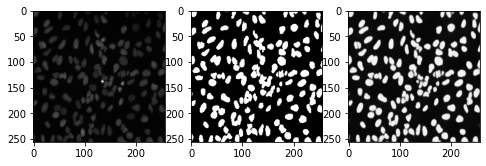

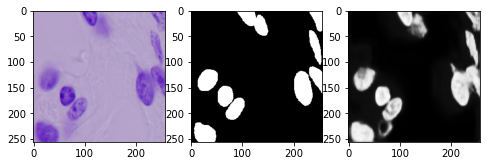

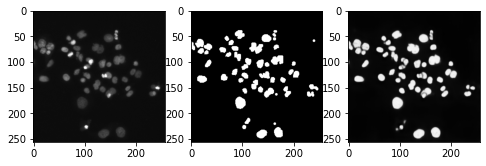

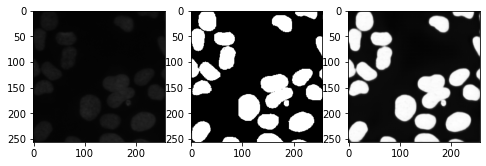

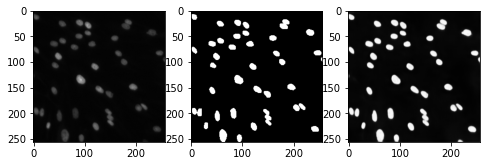

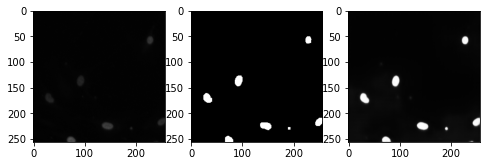

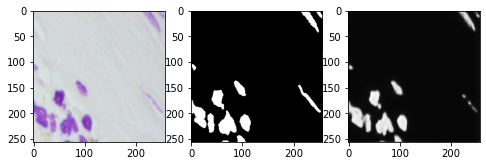

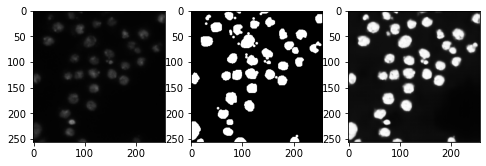

In [40]:
for image, mask in val_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.figure(figsize=(8,4))
        plt.subplot(131)
        plt.imshow(image[i])
        plt.subplot(132)
        plt.imshow(mask[i][:,:,0], cmap = 'gray')
        
        pred_mask  = model.predict(image[i][np.newaxis,:,:,:])
        plt.subplot(133)
        plt.imshow(pred_mask[0,:,:,0], cmap = 'gray')
        plt.show()

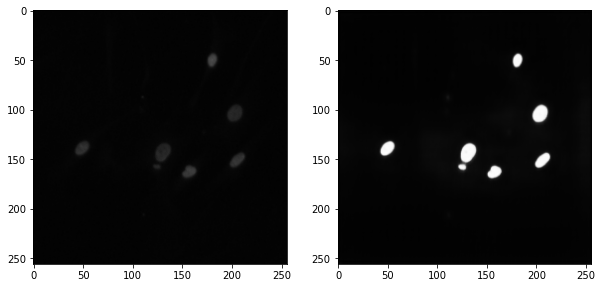

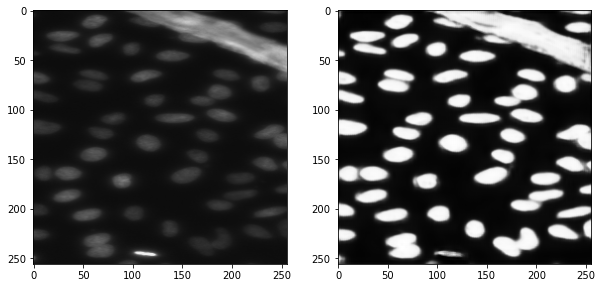

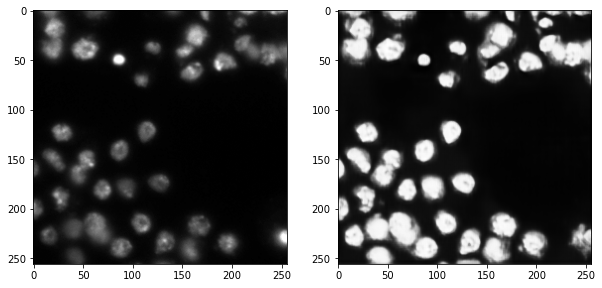

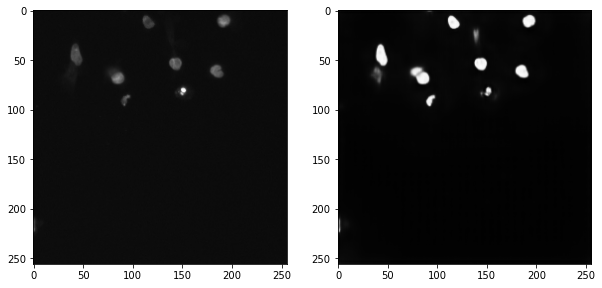

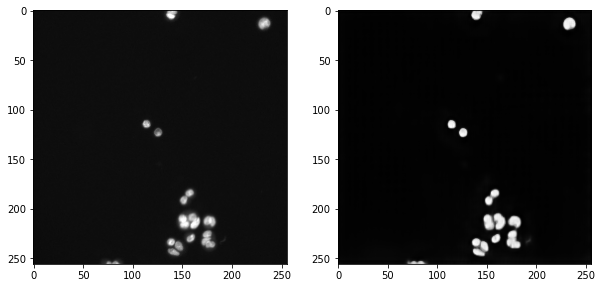

In [42]:
test_filenames = test_df['files']
for filename in test_filenames[:5]:
    file_path = os.path.join(filename,'images')
    image_path = os.path.join(file_path,os.listdir(file_path)[0])
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(pred_mask[0,:,:,0], cmap='gray')
    plt.show()

## EDA

In [43]:
# Function to create a dataframe with iou_scores and image and mask paths.
def metric_df(data):
    iou_scores = []
    m = MeanIoU(2, 0.4)
    for i in range(len(data)):
        image_path = data['images'].iloc[i]
        mask_path = data['masks'].iloc[i]
        image_string = tf.io.read_file(image_path)
        image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
        mask_string = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask_string, channels=CLASSES)#
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
        
        pred_mask = model.predict(image[np.newaxis,:,:,:])
        m.update_state(mask, pred_mask)
        iou_score = m.result().numpy()
        iou_scores.append(iou_score)
    data['iou_scores'] = iou_scores
    return data

In [44]:
df = X_train.copy()
df = metric_df(df)
df = df.sort_values('iou_scores')
df.head()

,images,masks,iou_scores
622,train\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8\images\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8.png,train\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8\masks_\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8.png,0.869897
666,train\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398\images\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398.png,train\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398\masks_\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398.png,0.870270
210,train\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9\images\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9.png,train\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9\masks_\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9.png,0.872304
176,train\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06\images\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06.png,train\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06\masks_\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06.png,0.873655
511,train\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a\images\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a.png,train\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a\masks_\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a.png,0.873666


In [45]:
df.tail()

,images,masks,iou_scores
70,train\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5\images\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5.png,train\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5\masks_\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5.png,0.924727
292,train\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699\images\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699.png,train\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699\masks_\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699.png,0.925037
30,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\images\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\masks_\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png,0.927326
60,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\images\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\masks_\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png,0.960217
300,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\images\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\masks_\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png,0.961802


# Best Output samples

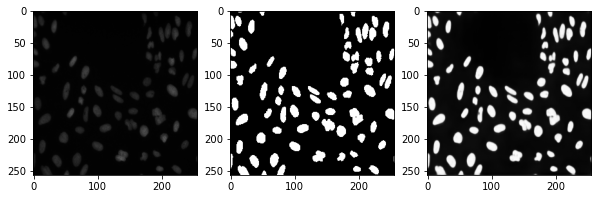

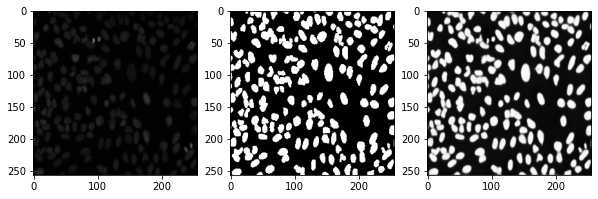

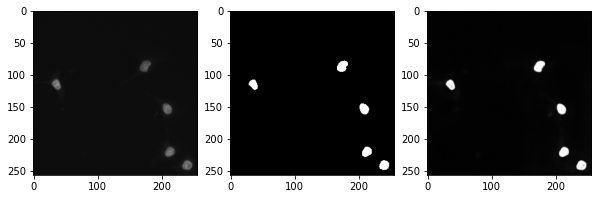

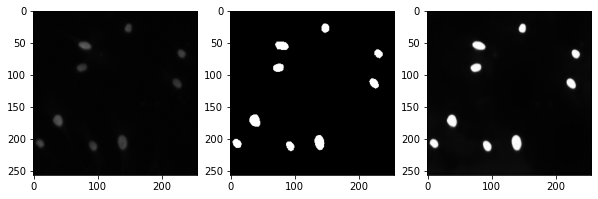

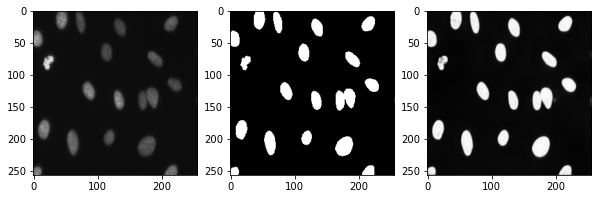

In [46]:
d1 = df.tail()
for i in range(5):
    image_path = d1['images'].iloc[i]
    mask_path = d1['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.subplot(133)
    plt.imshow(pred_mask[0,:,:,0], cmap='gray')

# Worst output sample

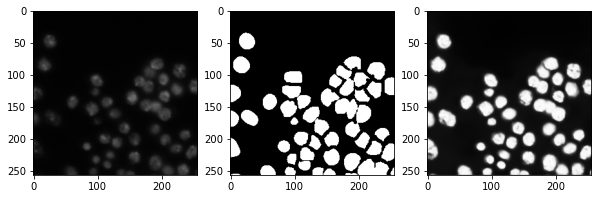

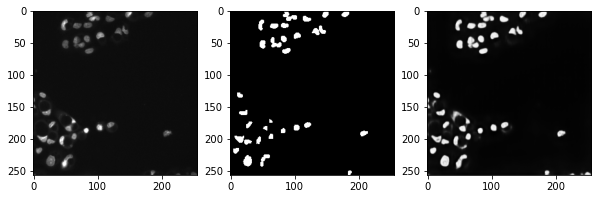

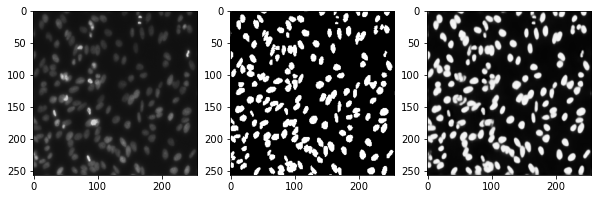

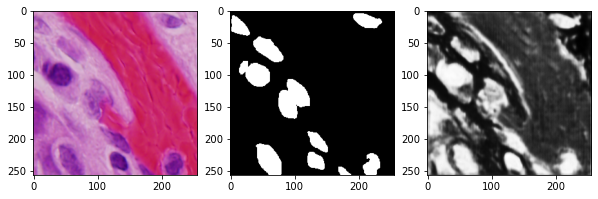

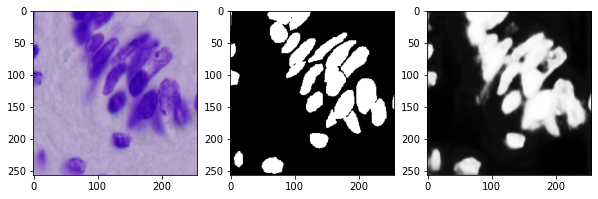

In [47]:
d2 = df.head()
for i in range(5):
    image_path = d2['images'].iloc[i]
    mask_path = d2['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.subplot(133)
    plt.imshow(pred_mask[0,:,:,0], cmap='gray')
    plt.show()

# Distribution of IoU scores

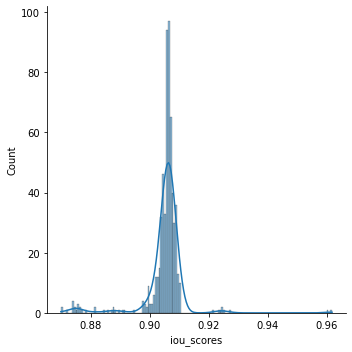

In [48]:
sns.displot(data=df, x="iou_scores", kde=True)

In [49]:
history

import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option("display.max_colwidth", -1)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Dropout,Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from PIL import Image, ImageStat
import math

%load_ext tensorboard
#seeding
seed = 2022
np.random.seed = seed
tf.seed = seed
TRAIN_ROOT_DIR = 'train'
TEST_ROOT_DIR = 'test'
# Function to create a dataframe of files which will be used for further processing
def files_df(root_dir):
    subdir = os.listdir(root_dir)
    files = []
    df = pd.DataFrame()
    for dir in subdir:
        files.append(os

In [51]:
model

In [67]:
model.save('./.',save_format='h5')

PermissionError: [Errno 13] Unable to create file (unable to open file: name = './.', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [68]:
model.save_weights("unet_model_15March.h5")